In [141]:
import gurobipy as gp
import numpy as np
import seaborn as sn
import pandas as pd

# Question 1

In [224]:
swimmers = ["N", "M", "L", "A", "C"]
styles = ["BA","BR","BU","FR"]
times = {("N","BA"): 40.1, ("N","BR"): 41.7, ("N","BU"): 41.1, ("N","FR"): 33.3,
         ("M","BA"): 39.6, ("M","BR"): 37.6, ("M","BU"): 31.9, ("M","FR"): 31.2,
         ("L","BA"): 35.3, ("L","BR"): 37.9, ("L","BU"): 36.2, ("L","FR"): 33.1,
         ("A","BA"): 30.6, ("A","BR"): 34.1, ("A","BU"): 33.3, ("A","FR"): 29.1,
         ("C","BA"): 36.9, ("C","BR"): 37.2, ("C","BU"): 29.0, ("C","FR"): 31.6}

model = gp.Model()
s = model.addVars(times, vtype = gp.GRB.BINARY, name = "relay",obj = times)
#the objective for minimization not defined because it's the default
#there have to be 4 swimmers, one for each style and the swimmers can't repeat in a relay
model.addConstrs(gp.quicksum(s[i,j] for i in swimmers) == 1 for j in styles)
model.addConstrs(gp.quicksum(s[i,j] for j in styles) <= 1 for i in swimmers)
#optimizing the model
model.optimize()
model.printAttr("X")

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x0c35683c
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 136.3000000
Presolve time: 0.00s
Presolved: 9 rows, 20 columns, 40 nonzeros
Variable types: 0 continuous, 20 integer (20 binary)
Found heuristic solution: objective 135.8000000

Root relaxation: objective 1.287000e+02, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     128.7000000  128.70000  0.00%     -    0s

Explored 1 nodes (8 simplex iterations) i

Solving the problem in Gurobi tells us the following solution: have Carol do the butterfly stroke, Asma do the backstroke, Lina do the breaststroke and Mary do the freestyle. Under this solution, it would take the team 128.7 seconds to finish the relay. 

# Question 2

## Part A

<AxesSubplot:>

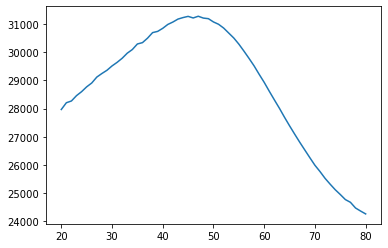

In [107]:
seats = 100
price1 = 150
price2 = 500
alpha = range(20,81)
n = 10000
expRevenues2 = []

for limit in alpha:
    #generate customers period 1
    customers1 = np.random.poisson(lam = 75, size = n)
    #sales based on booking limit
    p1sales = np.minimum(customers1,limit)
    #capacity
    remCap = 100 - p1sales
    #generate customers period 2
    customers2 = np.random.poisson(lam = 50, size = n)
    #sales based on capacity
    p2sales = np.minimum(customers2, remCap)
    #average the revenue across the 10k sims
    exprevenue = np.average(150*p1sales + 500*p2sales)
    #store our revenues for each booking limit
    expRevenues2.append(exprevenue)

sn.lineplot(alpha, expRevenues2)

In [119]:
limit_table = pd.DataFrame(
    {'Booking Limit': alpha,
     'Expected Revenue': expRevenues2
    })    
limit_tablelimit_table["Expected Revenue"]==max(limit_table["Expected Revenue"])

,Booking Limit,Expected Revenue
27,47,31268.89


In [120]:
max(expRevenues2)

31268.89

As we can see from the plot, in this particular simulation, the highest expected revenue comes from setting the booking limit at 47 for the first period. The optimal revenue here would be $31268.89.

## Part B

In [133]:
seats = 100
price1 = 150
price2 = 500
alpha = range(20,81)
#adding possible range of p
p = range(150,301)
n = 10000
expRevenues = []
bestChoice = []


for limit in alpha:
    for refund in p:
        customers1 = np.random.poisson(lam = 75, size = n)
        p1sales = np.minimum(customers1,limit)
        #probability of refund
        probRefund = (refund-150)/200 
        #number of refundable tickets
        refTickets = np.random.binomial(p1sales, probRefund) 
        remCap = 100 - p1sales
        #remaining cap including refundables
        remCapRef = remCap + refTickets
        customers2 = np.random.poisson(lam = 50, size = n)
        #sales can now go up to including refunds
        p2sales = np.minimum(customers2, remCapRef)
        #tickets that are refunded - can't be negative
        refunded = np.maximum(p2sales-remCap, 0)
        exprevenue = np.average(150*p1sales + 500*p2sales - refund*refunded)
        expRevenues.append(exprevenue)
    #for each limit we automatically store maximized revenue (best p)
    bestoption = max(expRevenues) 
    bestChoice.append(bestoption)
    #clear the expected revenues list (for each limit we want a fresh one)
    expRevenues = []
    
bestChoice

<AxesSubplot:xlabel='Booking Limit'>

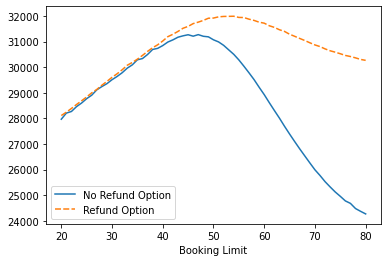

In [137]:
limit_table2 = pd.DataFrame(
    {'Booking Limit': alpha,
     'No Refund Option': expRevenues2,
     'Refund Option': bestChoice
    })    
dfAir= limit_table2.set_index(["Booking Limit"])
sn.lineplot(data = dfAir)

In [138]:
dfAir.loc[dfAir["Refund Option"]==max(dfAir["Refund Option"])]

,No Refund Option,Refund Option
Booking Limit,,
54,30498.885,31986.945


In [139]:
np.average(dfAir["Refund Option"]) - np.average(dfAir["No Refund Option"])

1970.5955163934414

In [140]:
max(dfAir["Refund Option"]) - max(dfAir["No Refund Option"])

718.0550000000003

The optimal revenue (assuming we always choose the optimal refund level) is \\$31,986.945. Based on the optimal revenues for both schemes, the value of the callable products scheme is \\$718.06. If we were to look at the average value of both schemes, then the value of the callable products is $1,970.6. The optimal booking limit with the callable products scheme is considerably higher at 54, compared to the 47 of the scheme without these products. As we can also see from the graph, the callable products scheme offsets the decrease in revenues caused by a higher booking limit, while keeping the same performance as the No Refund Option for lower booking limits. It is, therefore, highly recommended that the airline adopts this scheme. 

# Question 3

## Part A

In [223]:
productionCost = {"A": -11,"B":-11.5}
profit = {("A",1): 18.5, ("A",2):18, ("A",3):18, ("A",4):17,
        ("B",1): 18, ("B",2):18.8, ("B",3):18.9, ("B",4):17.5}
demands = {("a",1): 5000, ("a",2): 3000, ("a",3): 7800, ("a",4): 4000,
          ("b",1): 3000, ("b",2): 1000, ("b",3): 6000, ("b",4): 3000,
          ("c",1): 4200, ("c",2): 4100, ("c",3): 3000, ("c",4): 5400}
warehouses = ["A","B"]
distributionCenters = [1,2,3,4]
Scenarios = ["a","b","c"]
ScenarioProbs={"a": 0.3, "b": 0.2, "c": 0.5}

model = gp.Model()
#first stage variables
production = model.addVars(warehouses, name = "PF")
#second stage variables
shipping = model.addVars(Scenarios, warehouses, 
                         distributionCenters, name = "S")

#objective function
obj = gp.LinExpr()
obj+= gp.quicksum(productionCost[w]*production[w] 
                  for w in warehouses)
obj+= gp.quicksum(ScenarioProbs[s]*profit[(w,dc)]*shipping[(s,w,dc)] 
                  for s in Scenarios for dc in distributionCenters 
                  for w in warehouses)
model.setObjective(obj, gp.GRB.MAXIMIZE)

#second stage constraints (all of them)
#you can't transport more than you produce for each warehouse
model.addConstrs(gp.quicksum(shipping[(s,w,dc)] 
                             for dc in distributionCenters)<= 
                 production[w] for s in Scenarios for w in warehouses)
#what you ship shouldn't be higher than the demand
model.addConstrs(gp.quicksum(shipping[(s,w,dc)] 
                             for w in warehouses) <= demands[(s,dc)] 
                 for dc in distributionCenters for s in Scenarios)

model.optimize()
model.printAttr("X")


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 18 rows, 26 columns and 54 nonzeros
Model fingerprint: 0xc2e6b0bc
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 8e+03]
Presolve time: 0.01s
Presolved: 18 rows, 26 columns, 54 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4470000e+32   4.800000e+31   1.447000e+02      0s
      22    1.0499900e+05   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.049990000e+05

    Variable            X 
-------------------------
       PF[A]         6700 
       PF[B]        10000 
    S[a,A,1]         5000 
    S[a,A,2]          800 
    S[a,A,4]          900 
    S[a,B,2]         2200 
    S[a,B,3]         7800 
    S[b,A,1]         3000

Based on our model solution, we should send 6700 products to warehouse A and 10000 products to warehouse B. The expected profit of this solution is $104,999. 

## Part B(2)

In [211]:
dfdemand = pd.read_csv('demand.csv')
dfTC = pd.read_csv('TranportationCosts.csv')

In [ ]:
#we transform the warehouse and distribution center columns to index columns
#this allows to easily access the data using the W/DC name
dfTCindex = dfTC.set_index(["Warehouse"])
dfdemandIX = dfdemand.set_index(["DistributionCenter"])
#PF cost we take from the TC dataframe
#transp. cost we take from the TC dataframe
#demands we take from the demand dataframe
warehouses = dfTC["Warehouse"]
distributionCenters = dfdemand["DistributionCenter"]
Scenarios = list(dfdemandIX.columns)
ScenarioProbs = 0.01
fixedCost = -100000
profit = 20
prodCost = -10


model = gp.Model()
#first stage variables
production = model.addVars(warehouses, name = "PF")
nwarehouses = model.addVars(warehouses, vtype = gp.GRB.BINARY, name = "I")
#second stage variables
shipping = model.addVars(Scenarios, warehouses, distributionCenters, name = "S")

#objective function
obj = gp.LinExpr()
obj+= gp.quicksum(fixedCost*nwarehouses[w] for w in warehouses)
obj+= gp.quicksum((prodCost-dfTCindex.loc[w,"PFacility"])*production[w] 
                  for w in warehouses) 
obj+= gp.quicksum(ScenarioProbs*(profit-dfTCindex.loc[w,dc])*shipping[(s,w,dc)]
                  for s in Scenarios 
                  for dc in distributionCenters 
                  for w in warehouses)
model.setObjective(obj, gp.GRB.MAXIMIZE)

#second stage constraints (all of them)
#you can't transport more than you produce for each warehouse
model.addConstrs(gp.quicksum(shipping[(s,w,dc)] 
                             for dc in distributionCenters)<= production[w] 
                 for s in Scenarios for w in warehouses)
#should be lower than demand
model.addConstrs(gp.quicksum(shipping[(s,w,dc)] 
                             for w in warehouses) <= dfdemandIX.loc[dc,s] 
                 for dc in distributionCenters for s in Scenarios)
#indicator constraint
model.addConstrs(production[w] == production[w]*nwarehouses[w] 
                 for w in warehouses)

model.optimize()

In [221]:
model.getAttr("ObjVal")
#model.printAttr("X")

2124910.455000004

The adjusted model concludes that the fixed cost for each warehouse is so high that it only recommends using one warehouse in Stuttgart and subsequently send all the products from this warehouse to the different distribution centers. We produce and send 278,441 products to this single warehouse. The expected profit is $2,124,910.455. 

In [ ]:
#we create a new object to calculate the profit per scenario
array_shipping  = model.getAttr('X', shipping)
array_shipping

In [ ]:
scenarioprofit = 0
TotalProfit = {}

#run through all scenarios
for s in Scenarios:
    #for w in warehouses:
    #here only Stuttgart is the warehouse 
    #for each DC combination calculate profit
    for dc in distributionCenters:
        #add the profit for that scenario
        scenarioprofit+=array_shipping[s,"WH-Stuttgart",dc]*\
        (20-dfTCindex.loc["WH-Stuttgart",dc])
    #add the fixed cost and the PF cost
    finalprofit = scenarioprofit - 100000 + \
    (prodCost-dfTCindex.loc["WH-Stuttgart","PFacility"])*278441
    #store the scenario profit in a dictionary
    TotalProfit[s] = finalprofit
    scenarioprofit = 0

TotalProfit

<AxesSubplot:>

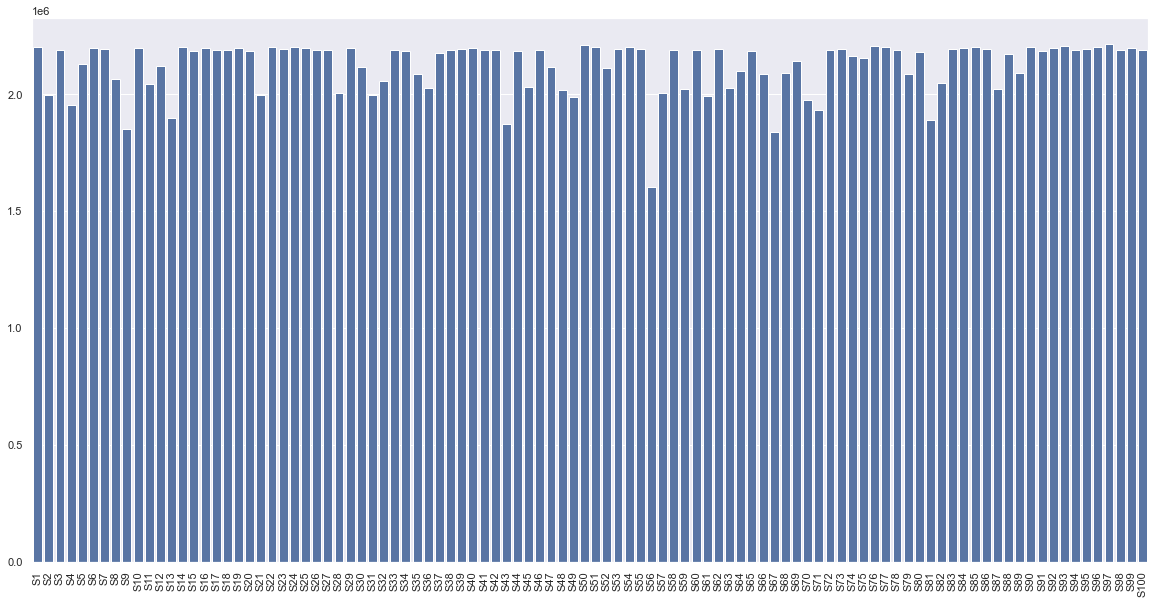

In [205]:
#these are just preparations to be able to create a chart
keys = list(TotalProfit.keys())
values = list(TotalProfit.values())
sn.set(rc={'figure.figsize':(20,10)})
chart = sn.barplot(x = keys, y = values, color = 'b', edgecolor = 'w')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart

In [213]:
min(values)

1601924.15

The worst case profit among all scenarios is $1,601,924.15, which happens under scenario 56. 